In [55]:
#########################################
# Cell 1
#########################################

import os
import glob
#images are divide into vehical or nonvehical folder
basedir = 'vehicles/'
image_types = os.listdir(basedir)
cars = []
for imtype in image_types:
    cars.extend(glob.glob(basedir+imtype+'/*'))

    
print('Number of vehicle Images found :',len(cars))
with open("cars.txt",'w') as f:
    for fn in cars:
        f.write(fn+'\n')

#for non vehicle images
basedir = 'non-vehicles/'
image_types = os.listdir(basedir)
notcars = []
for imtype in image_types:
    notcars.extend(glob.glob(basedir+imtype+'/*'))

    
print('Number of non-vehicle Images found :',len(notcars))
with open("notcars.txt",'w') as f:
    for fn in notcars:
        f.write(fn+'\n')


Number of vehicle Images found : 8792
Number of non-vehicle Images found : 8968


In [56]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [184]:
# Define a function of return HOG features and visulization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec= True):
    #call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell,pix_per_cell),
                                 cells_per_block=(cell_per_block,cell_per_block),transform_sqrt=True, 
                                  block_norm= 'L2-Hys',visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    #otherwise call with one output
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell,pix_per_cell),
                                 cells_per_block=(cell_per_block,cell_per_block),transform_sqrt=True,
                                 block_norm= 'L2-Hys',visualise=vis, feature_vector=feature_vec)
        return features
    
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

#Define a function to compute color histogram function
def color_hist(img, nbins=32):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    #concentrate the histograms into single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

#define a funtion to extract features from list of images
def extract_features(imgs,color_space='RGB', spatial_size=(32,32),hist_bins=32, orient=9,
                    pix_per_cell=8, cell_per_block= 2,hog_channel=0,
                    spatial_feat=True, hist_feat=True,hog_feat=True):
    features=[]
    for file in imgs:
        file_features=[]
        image = mpimg.imread(file)
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)
         
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            #apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat ==True:     
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features) 
        features.append(np.concatenate(file_features))
    return features
        

# Define a function that takes an image,start and stop positions in both x and y, window size (x and y dimensions),  
#and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
#     print("nx_pix_per_step: ", nx_pix_per_step)
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
#     print("ny_pix_per_step: ", ny_pix_per_step)
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
#     print("nx_windows: ", nx_windows)
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
#     print("ny_windows: ", ny_windows)
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    
    # Return the list of windows
    return window_list

#define a function to draw bounding boxes
def draw_boxes(img,bboxes,color=(0,0,255),thick =6):
    #make copy of image
    imcopy = np.copy(img)
    #iterate through bounding boxes
    for bbox in bboxes:
        #draw the reactangle given bboxes coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    #return the image copy with boxes drawn
    return imcopy

#define a function to extract feature from asingle image window
def single_img_features(img, color_space='RGB', spatial_size=(32,32), hist_bins=32, orient=9,
                        pix_per_cell=8,cell_per_block=2, hog_channel=0, spatial_feat=True, 
                        hist_feat=True, hog_feat=True, vis=False):

    
    #define an empty list to recive features
    img_features = []
    #appy color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLV)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
        
    #compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    if hist_feat == True:
        #apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                                     orient, pix_per_cell, cell_per_block, 
                                                     vis=False, feature_vec=True))
            hog_features = np.concatenate(hog_features)        
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                                           pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        img_features.append(hog_features) 
        
    if vis == True:
        return np.concatenate(img_features),hog_image
    else:
        return np.concatenate(img_features)
        
#define function  pass an image and the list window to be searched
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    
    #2) Iterate over all windows in the list
    for window in windows:
       
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))  
        
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, spatial_size=spatial_size, 
                                       hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                       cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                       spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        
        #5) Scale extracted features to be feed to classifier
        reshaped_array = np.array(features).reshape(1, -1)
        test_features = scaler.transform(reshaped_array)
        
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
            
    #8) Return windows for positive detections
    return on_windows
    
#define a function for plotting multiple images
def visualize(fig, rows, cols, imgs, titles):
    for i,img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])


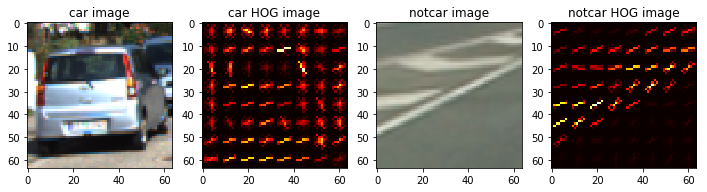

In [58]:
#########################################
# Cell 2
#########################################


%matplotlib inline

#choose random car/not-car indices
car_ind = np.random.randint(0,len(cars))
notcar_ind = np.random.randint(0,len(notcars))

#read in car /not car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

#define feature parameter
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9 # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features, car_hog_image = single_img_features(car_image, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, vis=True)
#print("Single image features", car_features.shape)
images = [car_image,car_hog_image,notcar_image,notcar_hog_image]
titles = ['car image','car HOG image','notcar image','notcar HOG image']
fig = plt.figure(figsize=(12,3))
visualize(fig, 1, 4, images, titles)


In [59]:

#########################################
# Cell 3
#########################################


#define feature parameters
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9 # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32   # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t=time.time()
n_samples = 1000
random_idxs = np.random.randint(0,len(cars), n_samples)
#print("index size", len(random_idxs))
test_cars =cars #np.array(cars)[random_idxs] 
#print("test cars size", len(test_cars))
test_notcars = notcars #np.array(notcars)[random_idxs] 
#print("test not cars size", len(test_notcars))

car_features = extract_features(test_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
#print("car_features length", len(car_features))
notcar_features = extract_features(test_notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
#print("noncar_features length", len(notcar_features))

print(time.time()-t, 'Seconds to compute features..')

X = np.vstack((car_features, notcar_features)).astype(np.float64)
#print("X length", len(X))

#fit a per-column scaler
#X_scaler = StandardScaler().fit(X)

#apply the scaler to X
#scaled_X = X_scaler.transform(X)

#define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

#print("y length", len(y))
#split up data into randomized training and test data 
rand_state =  np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=rand_state)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations,', pix_per_cell, 'pixels per cell,',cell_per_block,'cells per block ,'
      ,hist_bins,'histograms bins, and',spatial_size,'spatial sampling')
print('Feature vector length:',len(X_train[0]))

## Train a Classifier

#use linear SVC
svc = LinearSVC()
#check the traing time for svc
t = time.time()
svc.fit(X_train , y_train)
print(round(time.time()-t, 2),'Seconds to train SVC..')
#check the score of the SVC
print('Test accuracy of SVC = ',round(svc.score(X_test,y_test), 4))


215.73253107070923 Seconds to compute features..
Using: 9 orientations, 8 pixels per cell, 2 cells per block , 32 histograms bins, and (32, 32) spatial sampling
Feature vector length: 8460
176.05 Seconds to train SVC..
Test accuracy of SVC =  0.969


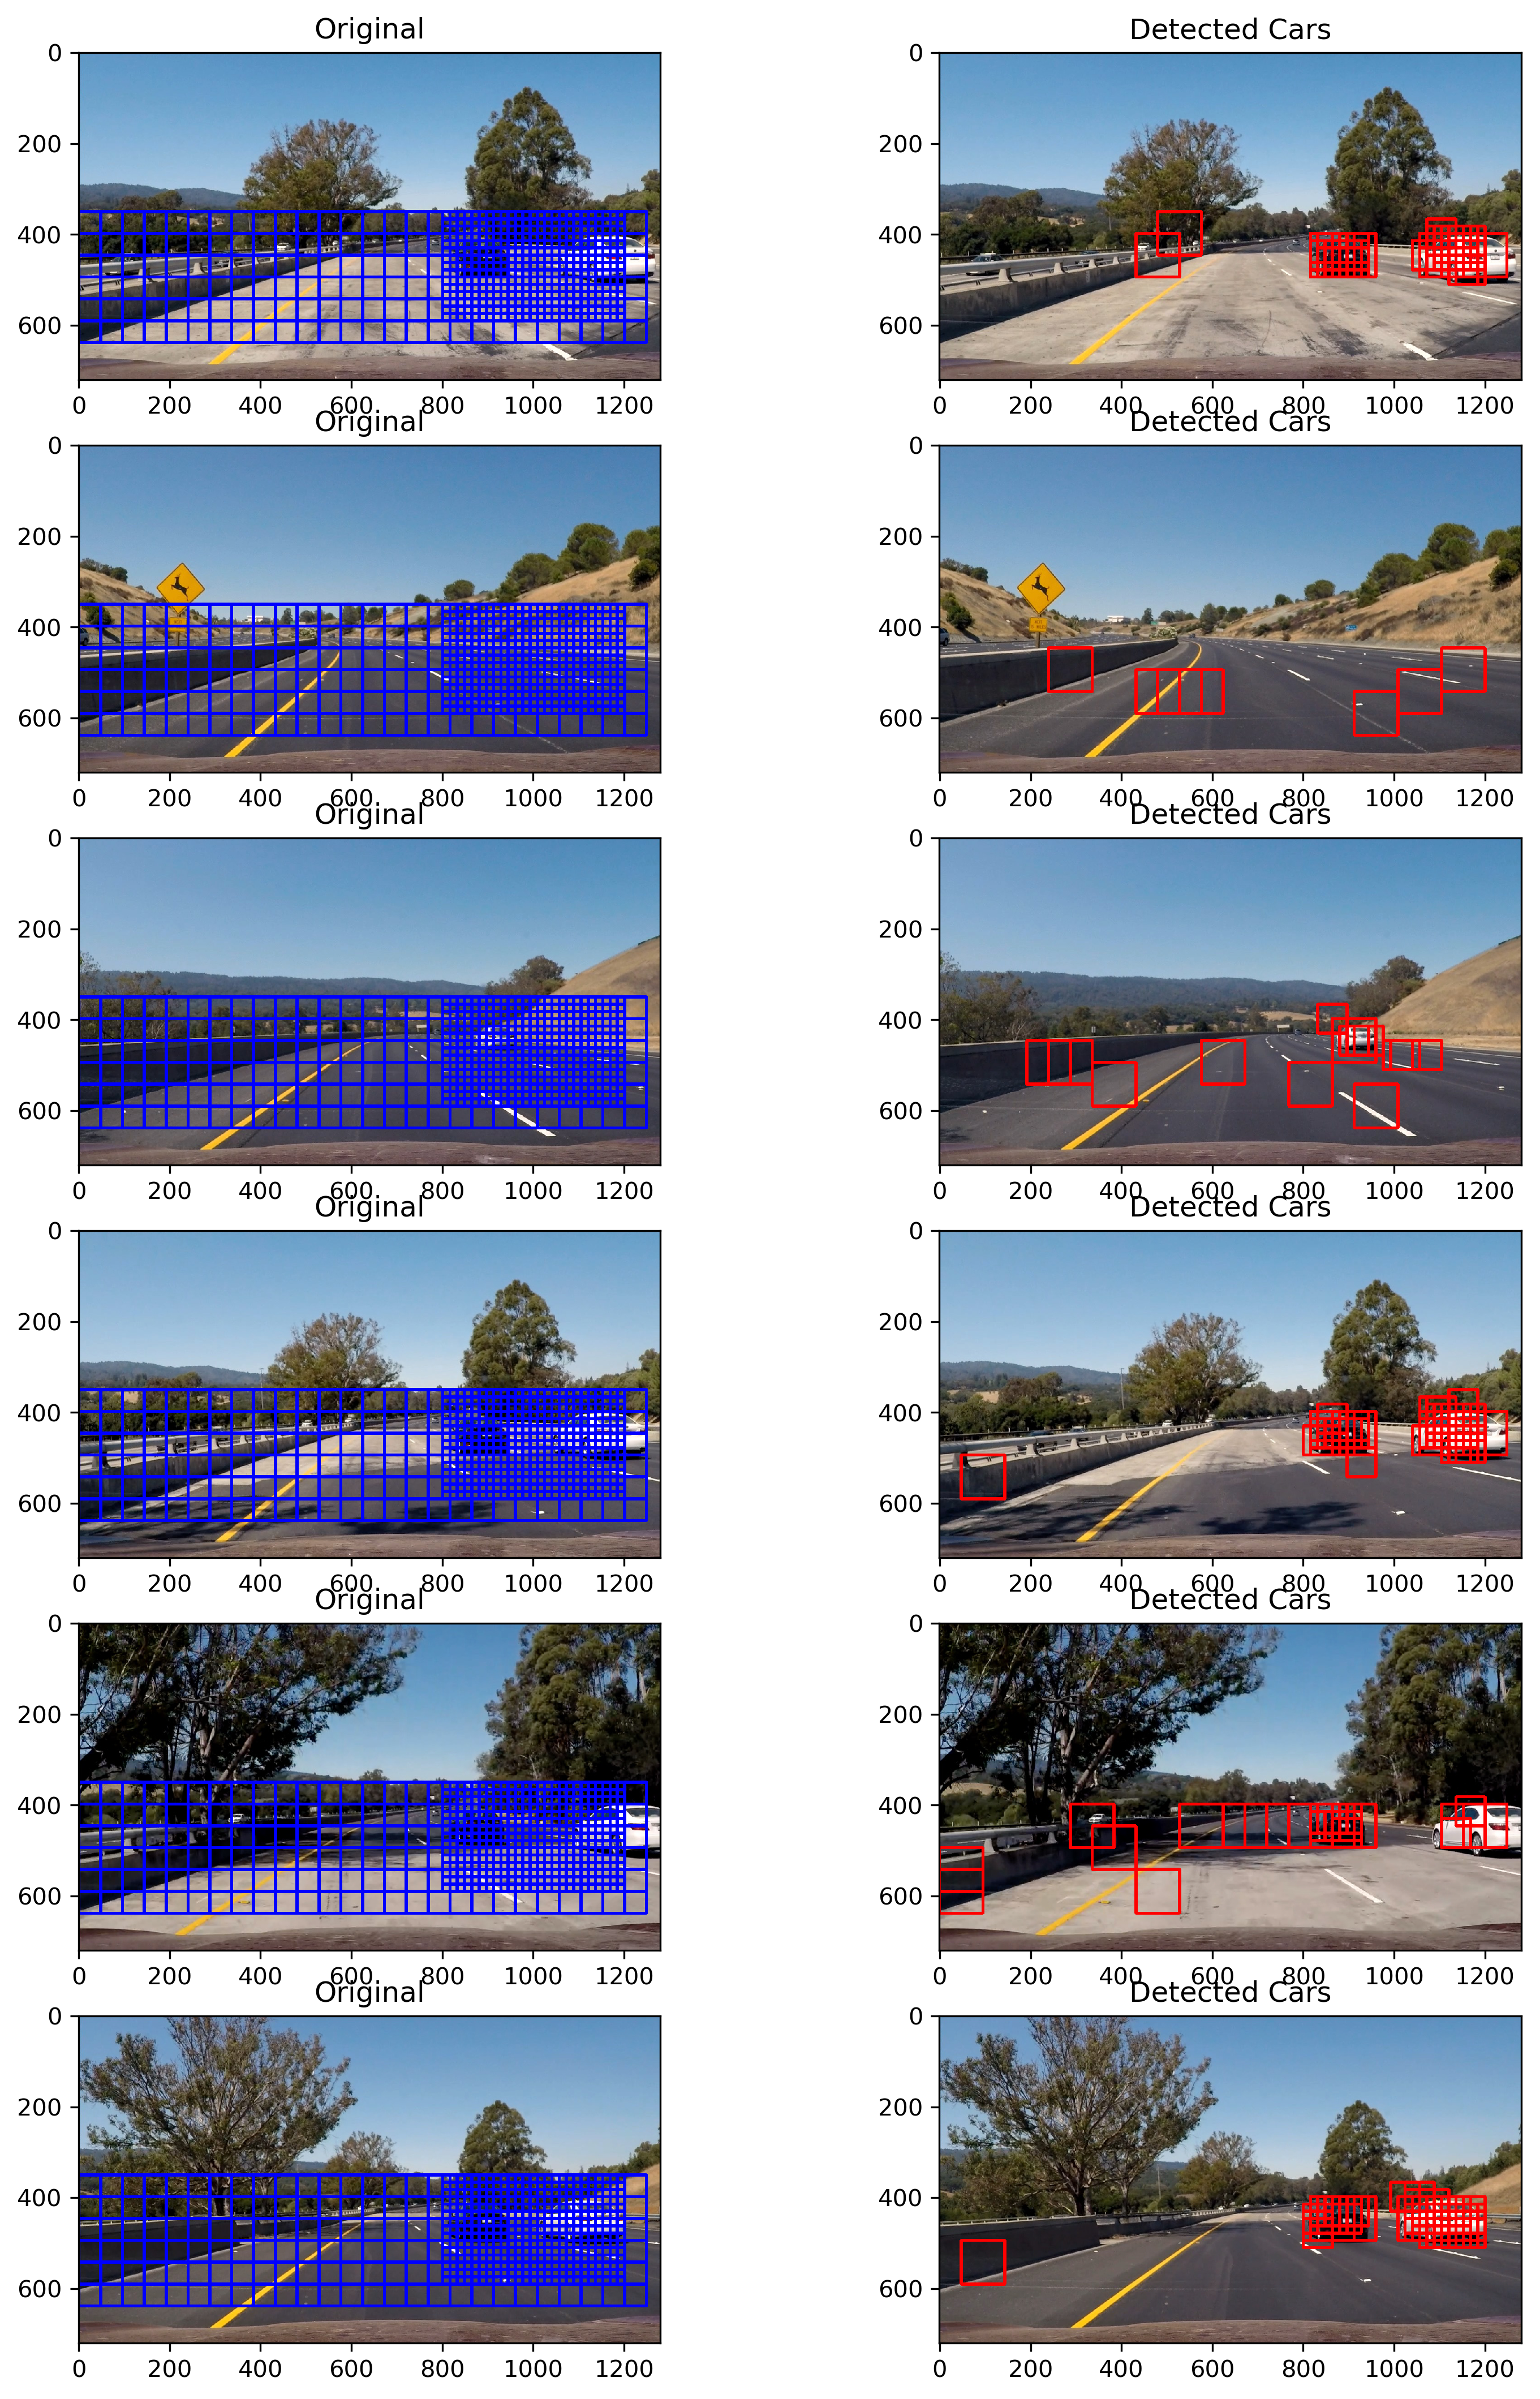

In [198]:
#########################################
# Cell 4
#########################################

searchpath = 'test_images/*'
example_images = glob.glob(searchpath)
images =[]
titles =[]
y_start_stop = [400,656]

y_start_stop_list = [[350,656], [350,600], [350,500]]
x_start_stop_list = [[None,None], [800,1200], [800,1200]]
overlap_list = [0.50, 0.75, 0.75]
xy_window_list = [(96, 96), (64, 64), (96, 128)]
color_list = [(0,0,255), (0,255,0), (255,255,255)]


for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    hot_windows_list = []
    windows_list = []
    
    window_img = None
    for i in range(2):
        windows = slide_window(img, x_start_stop=x_start_stop_list[i], y_start_stop=y_start_stop_list[i], 
                    xy_window=xy_window_list[i], xy_overlap=(overlap_list[i], overlap_list[i]))
    
    
        hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
        hot_windows_list.extend(hot_windows)
        windows_list.extend(windows)

    window_img = draw_boxes(draw_img, windows_list, color=(0,0,255),thick=6)
    images.append(window_img)
    
    window_img = draw_boxes(draw_img, hot_windows_list, color=(255,0,0),thick=6)
    images.append(window_img)
    
    titles.append('Original')
    titles.append('Detected Cars')
#     print(time.time()-t1,'Seconds to process one image searching',len(windows),'windows')
    
fig = plt.figure(figsize=(12,24), dpi=300)
visualize(fig, 8, 2, images, titles)

In [214]:
def convert_color(img, conv ='RGB2YCrCBb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img,cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img,cv2.COLOR_BGR2YCrCb) 
    if conv == 'RGB2YLUV':
        return cv2.cvtColor(img,cv2.COLOR_RGB2LUV) 
 

In [215]:
from scipy.ndimage.measurements import label

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def add_heat_5(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 5

    # Return updated heatmap
    return heatmap

def draw_labeled_bboxes_new(img, labels,scale=1):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox)*scale, np.min(nonzeroy)*scale), (np.max(nonzerox)*scale, np.max(nonzeroy)*scale))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


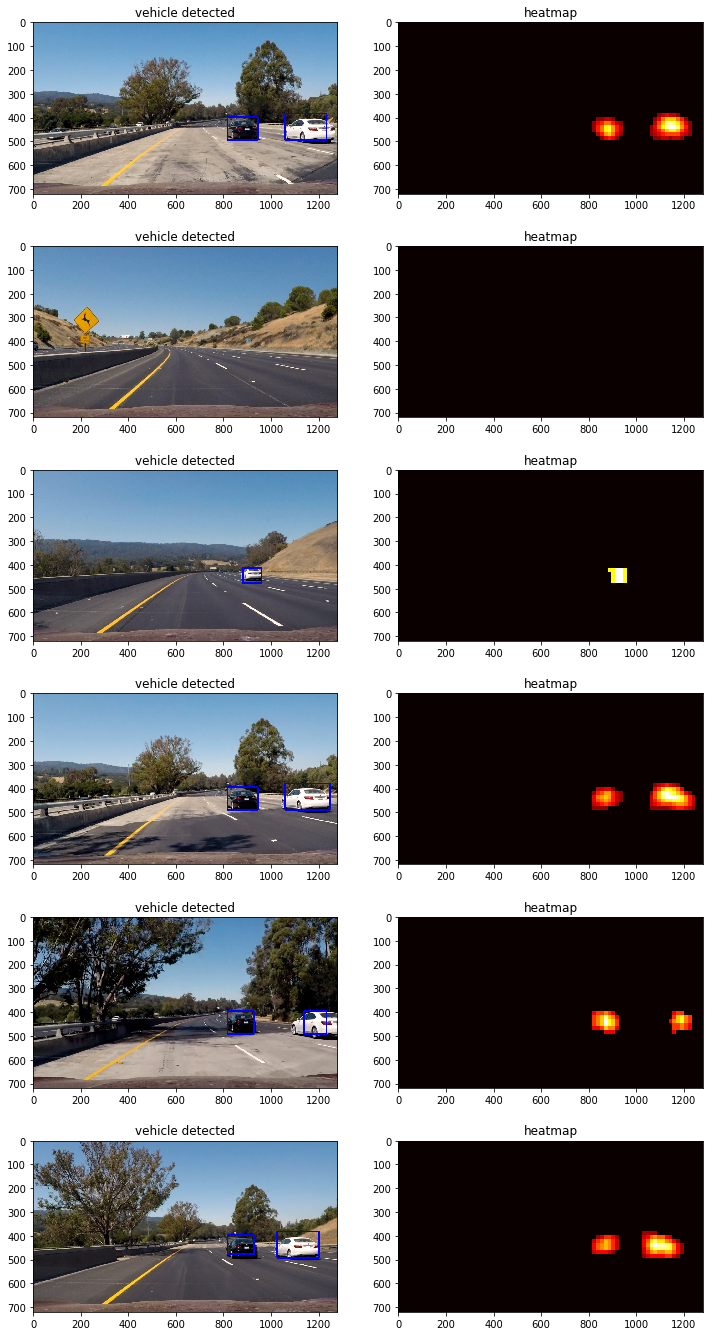

In [216]:
#########################################
# Cell 5
#########################################


searchpath = 'test_images/*'
example_images = glob.glob(searchpath)
images =[]
titles =[]
y_start_stop = [400,656]
overlap = 0.50

y_start_stop_list = [[350,656], [350,500], [350,600]]
x_start_stop_list = [[None,None], [800,None], [800,None]]
overlap_list = [0.50, 0.75, 0.75]
xy_window_list = [(96, 96), (64, 64), (96, 128)]
color_list = [(0,0,255), (0,255,0), (255,255,255)]


for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    hot_windows_list = []
    
    for i in range(2):
        windows = slide_window(img, x_start_stop=x_start_stop_list[i], y_start_stop=y_start_stop_list[i], 
                    xy_window=xy_window_list[i], xy_overlap=(overlap_list[i], overlap_list[i]))
    
    
        hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
        hot_windows_list.extend(hot_windows)
    

    titles.append('vehicle detected')
    titles.append('heatmap')
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, hot_windows_list)
    heat = apply_threshold(heatmap=heat, threshold= 2)
    heat = np.clip(heat, 0, 255)
    labels = label(heat)
    #draw bunding boxes on acopy of image
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    images.append(draw_img)
    images.append(heat)
    
fig = plt.figure(figsize=(12,24))
visualize(fig, 6, 2, images, titles)


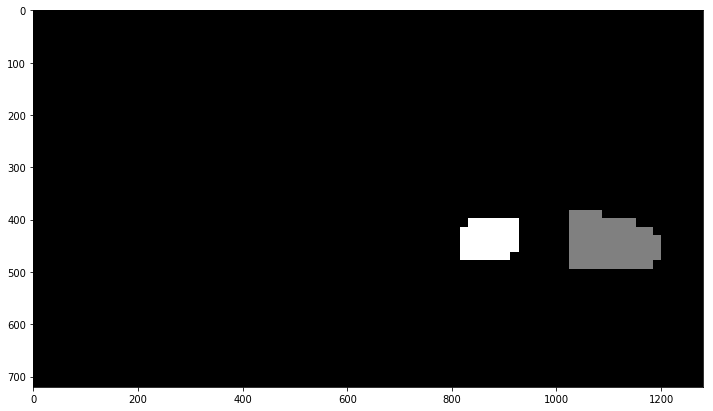

In [217]:
plt.figure(figsize=(12,12))
plt.imshow(labels[0], cmap='gray')

In [190]:
def process_image_new(img_src):
    
    global rect_db
    
    y_start_stop_list = [[350,656], [350,500], [350,600]]
    x_start_stop_list = [[None,None], [800,None], [800,None]]
    overlap_list = [0.50, 0.75, 0.75]
    xy_window_list = [(96, 96), (64, 64), (96, 128)]
    color_list = [(0,0,255), (0,255,0), (255,255,255)]


    t1 = time.time()
    
    draw_img = np.copy(img_src)
    img = img_src.astype(np.float32)/255
    
    hot_windows_list = []
    
    windows_list = []

    
    for i in range(2):
        #print("Pass: ",i+1, "y:",y_start_stop_list[i], "x:",x_start_stop_list[i])
        windows = slide_window(img, x_start_stop=x_start_stop_list[i], y_start_stop=y_start_stop_list[i], 
                    xy_window=xy_window_list[i], xy_overlap=(overlap_list[i], overlap_list[i]))

        
        hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                                    spatial_size=spatial_size, hist_bins=hist_bins, 
                                    orient=orient, pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                    hist_feat=hist_feat, hog_feat=hog_feat)
        
        hot_windows_list.extend(hot_windows)

        windows_list.extend(windows)
    
    rect_db.append(hot_windows_list)
    
    if len(rect_db) > 3:
        rect_db = rect_db[1:]
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    for rect in rect_db:
        heat = add_heat(heat, rect)
        
    heat = apply_threshold(heatmap=heat, threshold= 10)
    heat = np.clip(heat, 0, 255)
    labels = label(heat)
    
    #draw bunding boxes on acopy of image
    draw_img = draw_labeled_bboxes(draw_img, labels)
    
    return draw_img


In [194]:
#import everything neded to edit/save/ watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

rect_db = []

test_output = 'project_video_output_4.mp4'
clip = VideoFileClip("project_video.mp4")
test_clip = clip.fl_image(process_image_new)
#%time
test_clip.write_videofile(test_output, audio=False)


[MoviePy] >>>> Building video project_video_output_4.mp4
[MoviePy] Writing video project_video_output_4.mp4



 12%|█▏        | 151/1261 [06:47<47:40,  2.58s/it]


 24%|██▍       | 302/1261 [13:25<41:40,  2.61s/it]


 36%|███▌      | 453/1261 [20:02<35:08,  2.61s/it]


 48%|████▊     | 604/1261 [26:37<28:21,  2.59s/it]


 60%|█████▉    | 755/1261 [33:10<21:53,  2.60s/it]


 72%|███████▏  | 906/1261 [39:45<15:32,  2.63s/it]


 84%|████████▎ | 1056/1261 [46:17<08:50,  2.59s/it]


 95%|█████████▌| 1204/1261 [52:44<02:27,  2.59s/it]


100%|█████████▉| 1260/1261 [55:09<00:02,  2.59s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_4.mp4 



0

In [195]:
HTML(""" 
<video width="760" height="540" controls>
  <source src="project_video_output_3.mp4">
</video>
""".format(test_output))
